Calibrated SVI slices: 5
w(T,y) surface shape: (30, 121)


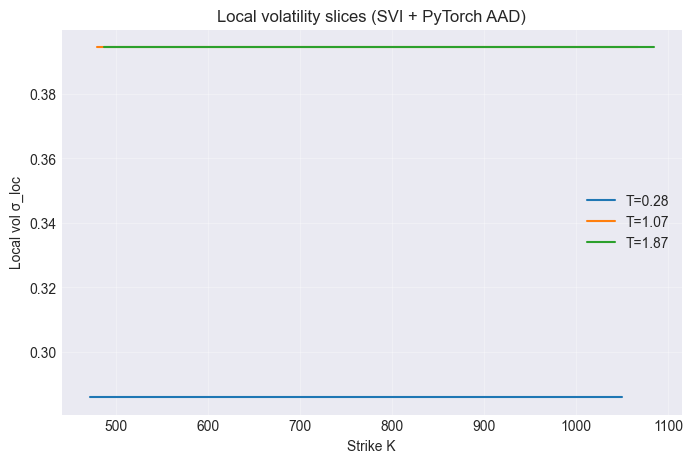

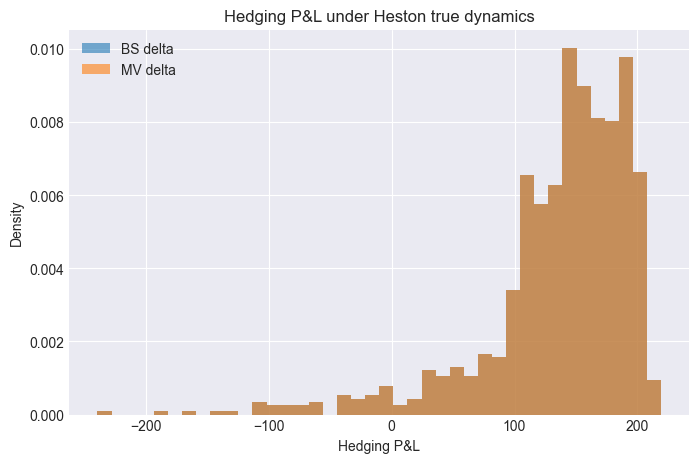

P&L stats (mean, std):
BS delta: 136.4278035220406 61.39030957444434
MV delta: 136.42780359189402 61.39030950693191


In [1]:
# %% [markdown]
# # Local Volatility, Heston & Minimum-Variance Delta – End-to-End Notebook
#
# This notebook implements an end-to-end pipeline for equity-options smile modelling and hedging:
#
# 1. **Market data & implied vols** (synthetic here, plug your own)
# 2. **SVI calibration** for each expiry
# 3. **Local volatility surface** via Gatheral's Dupire formula using **PyTorch autograd** (no noisy finite differences)
# 4. **Monte Carlo engines**
#    - Local volatility (Dupire)
#    - Heston stochastic volatility
# 5. **Greeks & deltas**
#    - Black–Scholes delta & vega
#    - Approximate Minimum-Variance (MV) delta using smile/skew
# 6. **Hedging experiments**
#    - Simulate under LV or Heston
#    - Hedge with Black–Scholes vs MV delta
#    - Compare P&L distributions
#
# Replace the synthetic data section with real SPX/SPY options and you’re off to the races.

# %%
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import scipy.optimize as opt
import scipy.interpolate as si

import torch
from scipy.stats import norm

torch.set_default_dtype(torch.float64)
device = "cpu"  # change to "cuda" if you have a GPU

plt.style.use("seaborn-v0_8-darkgrid")

# %% [markdown]
# ## Black–Scholes utilities

# %%
def bs_call_price(S, K, r, q, T, sigma):
    if T <= 0 or sigma <= 0:
        return max(S * math.exp(-q*T) - K * math.exp(-r*T), 0.0)
    F = S * math.exp((r - q) * T)
    df = math.exp(-r * T)
    vol_sqrt_T = sigma * math.sqrt(T)
    d1 = (math.log(F / K) + 0.5 * sigma * sigma * T) / vol_sqrt_T
    d2 = d1 - vol_sqrt_T
    return df * (F * norm.cdf(d1) - K * norm.cdf(d2))

def bs_call_delta(S, K, r, q, T, sigma):
    if T <= 0 or sigma <= 0:
        return 1.0 if S > K else 0.0
    F = S * math.exp((r - q) * T)
    vol_sqrt_T = sigma * math.sqrt(T)
    d1 = (math.log(F / K) + 0.5 * sigma * sigma * T) / vol_sqrt_T
    return math.exp(-q*T) * norm.cdf(d1)

def bs_call_vega(S, K, r, q, T, sigma):
    if T <= 0 or sigma <= 0:
        return 0.0
    F = S * math.exp((r - q) * T)
    vol_sqrt_T = sigma * math.sqrt(T)
    d1 = (math.log(F / K) + 0.5 * sigma * sigma * T) / vol_sqrt_T
    return math.exp(-r*T) * F * norm.pdf(d1) * math.sqrt(T)

def bs_implied_vol(target_price, S, K, r, q, T, tol=1e-6, max_iter=100):
    """Simple bisection IV solver for calls."""
    if target_price <= 0 or T <= 0:
        return np.nan
    low, high = 1e-4, 5.0
    for _ in range(max_iter):
        mid = 0.5*(low+high)
        price = bs_call_price(S,K,r,q,T,mid)
        if abs(price-target_price) < tol:
            return mid
        if price > target_price:
            high = mid
        else:
            low = mid
    return mid

# %% [markdown]
# ## Synthetic market data (replace with real SPX/SPY options)
#
# If you already have a `df_calls` DataFrame with columns:
#
# - `expiry` (datetime64)
# - `strike`
# - `mid` (mid price)
# - `F` (forward price)
# - `time_to_expiry` (year fraction)
# - `impl_vol` (Black–Scholes IV)
# - `y` = log-moneyness = ln(K/F)
# - `w` = total variance = T * IV²
#
# then **skip this cell** and just assign your own `df_calls`.

# %%
S0 = 700.0
R = 0.03      # risk-free
Q = 0.01      # dividend yield

np.random.seed(42)

expiries_days = np.array([30, 90, 180, 365, 730])
expiries_T = expiries_days / 365.0

rows = []
for T in expiries_T:
    F = S0 * math.exp((R-Q)*T)
    for moneyness in np.linspace(0.7, 1.3, 15):
        K = F * moneyness
        # "true" smile for synthetic data
        base = 0.25 + 0.05*T
        skew = 0.2*(moneyness-1.0)
        smile = base + 0.5*skew**2
        sigma_true = max(smile, 0.05)
        price = bs_call_price(S0, K, R, Q, T, sigma_true)
        mid = price * (1.0 + 0.01*np.random.randn())
        rows.append((pd.Timestamp.today().normalize() + pd.Timedelta(days=int(T*365)),
                     K, mid, F, T))

df_calls = pd.DataFrame(rows, columns=["expiry","strike","mid","F","time_to_expiry"])

# compute IVs
ivs = []
for _, row in df_calls.iterrows():
    ivs.append(bs_implied_vol(row["mid"], S0, row["strike"], R, Q, row["time_to_expiry"]))
df_calls["impl_vol"] = ivs
df_calls = df_calls.dropna(subset=["impl_vol"])

df_calls["y"] = np.log(df_calls["strike"]/df_calls["F"])
df_calls["w"] = df_calls["time_to_expiry"] * df_calls["impl_vol"]**2

df_calls.head()

# %% [markdown]
# ## SVI calibration per expiry

# %%
def svi_total_variance_np(y, a, b, rho, m, sigma):
    return a + b * (rho*(y-m) + np.sqrt((y-m)**2 + sigma**2))

def calibrate_svi_slice(y_slice, w_slice, guess=None):
    y_slice = np.asarray(y_slice)
    w_slice = np.asarray(w_slice)

    if guess is None:
        a0 = np.min(w_slice)
        b0 = 0.5*(np.max(w_slice)-np.min(w_slice))
        rho0 = -0.3
        m0 = np.median(y_slice)
        sigma0 = 0.1
        guess = np.array([a0,b0,rho0,m0,sigma0])

    bounds = [
        (1e-8,5.0), (1e-8,5.0),
        (-0.999,0.999),
        (y_slice.min()-2.0, y_slice.max()+2.0),
        (1e-4,5.0),
    ]
    def obj(theta):
        a,b,rho,m,sig = theta
        w_model = svi_total_variance_np(y_slice,a,b,rho,m,sig)
        pen = np.sum(np.minimum(w_model,0.0)**2)   # enforce w >= 0
        return np.mean((w_model-w_slice)**2) + 1e3*pen

    res = opt.minimize(obj, guess, bounds=bounds, method="L-BFGS-B")
    return res.x, res.fun, res.success

T_col = "time_to_expiry"

df_sliceable = df_calls.copy()
df_sliceable = df_sliceable[
    (df_sliceable["impl_vol"]>0.01) &
    (df_sliceable["impl_vol"]<3.0) &
    (df_sliceable["w"]>0)
].copy()

min_strikes_per_slice = 8
svi_theta_list = []
T_raw_list = []

for expiry, g in df_sliceable.groupby("expiry"):
    if len(g) < min_strikes_per_slice:
        continue
    g = g.sort_values("y")
    y_slice = g["y"].values
    w_slice = g["w"].values
    T_i = float(g[T_col].iloc[0])
    theta, mse, ok = calibrate_svi_slice(y_slice,w_slice)
    if not ok:
        print("SVI failed for", expiry)
        continue
    svi_theta_list.append(theta)
    T_raw_list.append(T_i)

T_raw = np.array(sorted(T_raw_list))
order = np.argsort(T_raw_list)
Theta = np.array(svi_theta_list)[order]

print("Calibrated SVI slices:", len(T_raw))

# %% [markdown]
# ## Local volatility via Gatheral formula using PyTorch autograd
#
# We define:
#
# \[
# w(T,y) = \text{total variance}, \quad y = \log(K/F_T)
# \]
#
# For \(T\) between two calibrated expiries \(T_i < T < T_{i+1}\) we set
#
# \[
# w(T,y) = \frac{T_{i+1}-T}{T_{i+1}-T_i}\,w(T_i,y)
#          + \frac{T-T_i}{T_{i+1}-T_i}\,w(T_{i+1},y).
# \]
#
# Using PyTorch, we differentiate analytically to obtain
# \(w_T, w_y, w_{yy}\) and plug into Gatheral’s formula.

# %%
torch.set_default_dtype(torch.float64)
device = "cpu"

T_raw_t = torch.tensor(T_raw, device=device)
Theta_t = torch.tensor(Theta, device=device)
n_T_raw = T_raw_t.shape[0]

def svi_total_variance_torch(y, theta):
    a,b,rho,m,sigma = theta.unbind()
    return a + b*(rho*(y-m) + torch.sqrt((y-m)**2 + sigma**2))

def w_and_wT_torch(T, y_vec):
    """Return w(T,y), w_T(T,y) for scalar T and vector y."""
    T_scalar = torch.tensor(T, device=device)
    idx = torch.bucketize(T_scalar, T_raw_t) - 1
    idx = torch.clamp(idx, 0, n_T_raw-2)

    T0 = T_raw_t[idx]
    T1 = T_raw_t[idx+1]
    theta0 = Theta_t[idx]
    theta1 = Theta_t[idx+1]

    w0 = svi_total_variance_torch(y_vec, theta0)
    w1 = svi_total_variance_torch(y_vec, theta1)

    w = ((T1-T_scalar)*w0 + (T_scalar-T0)*w1)/(T1-T0)
    w_T = (w1-w0)/(T1-T0)
    return w, w_T

# grids
y_all = df_sliceable["y"].values
y_center = np.median(y_all)
y_min = y_center - 0.4
y_max = y_center + 0.4
n_y = 121
y_grid = np.linspace(y_min, y_max, n_y)

T_min, T_max = float(T_raw.min()), float(T_raw.max())
n_T = 30
T_grid = np.linspace(T_min, T_max, n_T)

W_np   = np.zeros((n_T, n_y))
wT_np  = np.zeros((n_T, n_y))
wY_np  = np.zeros((n_T, n_y))
wYY_np = np.zeros((n_T, n_y))

for i,T_val in enumerate(T_grid):
    y = torch.tensor(y_grid, device=device, requires_grad=True)
    w, w_T = w_and_wT_torch(T_val, y)

    w_sum = w.sum()
    w_y = torch.autograd.grad(w_sum, y, create_graph=True)[0]
    w_y_sum = w_y.sum()
    w_yy = torch.autograd.grad(w_y_sum, y)[0]

    W_np[i,:]   = w.detach().cpu().numpy()
    wT_np[i,:]  = w_T.detach().cpu().numpy()
    wY_np[i,:]  = w_y.detach().cpu().numpy()
    wYY_np[i,:] = w_yy.detach().cpu().numpy()

W_np  = np.maximum(W_np, 1e-8)
wT_np = np.maximum(wT_np, 0.0)

print("w(T,y) surface shape:", W_np.shape)

# %%
# Gatheral local volatility

Y, TT = np.meshgrid(y_grid, T_grid)
w = W_np

term1 = 1.0 - (Y / w) * wY_np
term2 = 0.25 * (-1.0 - (Y**2)/(w**2)) * (wY_np**2)
term3 = 0.5 * wYY_np
D = term1 + term2 + term3

D_safe = np.where(D > 0, np.maximum(D, 5e-3), 5e-3)

sigma2_loc = wT_np / D_safe
sigma2_loc = np.maximum(sigma2_loc, 0.0)
sigma_loc = np.sqrt(sigma2_loc)
sigma_loc = np.clip(sigma_loc, 0.0, 3.0)  # cap for plotting

# Map (T,y) to (T,K)
K_grid = np.zeros_like(W_np)
for i, T_i in enumerate(T_grid):
    F_i = S0 * math.exp((R-Q)*T_i)
    K_grid[i,:] = F_i * np.exp(y_grid)

plt.figure(figsize=(8,5))
for T_target in [T_grid[3], T_grid[len(T_grid)//2], T_grid[-3]]:
    i = np.argmin(np.abs(T_grid - T_target))
    plt.plot(K_grid[i,:], sigma_loc[i,:], label=f"T={T_grid[i]:.2f}")
plt.xlabel("Strike K")
plt.ylabel("Local vol σ_loc")
plt.title("Local volatility slices (SVI + PyTorch AAD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# %% [markdown]
# ## Monte Carlo engines: Local Vol & Heston

# %%
def interp_local_vol(t, S):
    """Bilinear interpolation of σ_loc at arbitrary (t,S)."""
    t = np.clip(t, T_grid[0], T_grid[-1])
    i = np.searchsorted(T_grid, t) - 1
    i = np.clip(i, 0, len(T_grid)-2)
    t0, t1 = T_grid[i], T_grid[i+1]
    wt = (t - t0) / (t1 - t0 + 1e-16)

    def interp_sigma_at(i_level):
        Ks = K_grid[i_level]
        sigs = sigma_loc[i_level]
        if S <= Ks[0]:
            return sigs[0]
        if S >= Ks[-1]:
            return sigs[-1]
        j = np.searchsorted(Ks, S) - 1
        j = np.clip(j, 0, len(Ks)-2)
        K0, K1 = Ks[j], Ks[j+1]
        wk = (S - K0) / (K1 - K0 + 1e-16)
        return (1-wk)*sigs[j] + wk*sigs[j+1]

    sig0 = interp_sigma_at(i)
    sig1 = interp_sigma_at(i+1)
    return (1-wt)*sig0 + wt*sig1

def simulate_local_vol_paths(n_paths=2000, n_steps=100, T=1.0, S0=S0, r=R, q=Q, seed=1234):
    dt = T/n_steps
    rng = np.random.default_rng(seed)
    S = np.full(n_paths, S0, dtype=float)
    paths = np.zeros((n_steps+1, n_paths))
    paths[0,:] = S0
    t = 0.0
    for k in range(1, n_steps+1):
        z = rng.standard_normal(n_paths)
        sig = np.array([interp_local_vol(t, s) for s in S])
        dW = np.sqrt(dt)*z
        S *= np.exp((r-q-0.5*sig**2)*dt + sig*dW)
        paths[k,:] = S
        t += dt
    return paths

def simulate_heston_paths(
    n_paths=2000, n_steps=100, T=1.0,
    S0=S0, r=R, q=Q,
    kappa=2.0, theta=0.04, sigma_v=0.5, rho=-0.7, v0=0.04,
    seed=1234
):
    dt = T/n_steps
    rng = np.random.default_rng(seed)
    S = np.full(n_paths, S0, dtype=float)
    v = np.full(n_paths, v0, dtype=float)
    paths = np.zeros((n_steps+1, n_paths))
    paths[0,:] = S0
    for k in range(1, n_steps+1):
        z1 = rng.standard_normal(n_paths)
        z2 = rng.standard_normal(n_paths)
        dW1 = np.sqrt(dt)*z1
        dW2 = np.sqrt(dt)*(rho*z1 + np.sqrt(1-rho**2)*z2)
        v = np.maximum(v, 0.0)
        v += kappa*(theta-v)*dt + sigma_v*np.sqrt(v)*dW2
        v = np.maximum(v, 0.0)
        S *= np.exp((r-q-0.5*v)*dt + np.sqrt(v)*dW1)
        paths[k,:] = S
    return paths

# %% [markdown]
# ## Minimum-Variance Delta: derivation and implementation
#
# For a European call with price \(C(S, \sigma_{\text{imp}}(K,T))\),
# if the implied vol moves with the underlying (sticky-delta), the **delta of the call**
# is affected not just by \(S\) but also by the *smile dynamics*.
#
# Linearising, a small move in \(S\) changes the price by
#
# \[
# dC \approx \Delta_{\text{BS}}\,dS + \text{Vega}\,\frac{\partial \sigma_{\text{imp}}}{\partial S} dS.
# \]
#
# The **minimum-variance delta** that minimises the variance of hedging P\&L is approximately
#
# \[
# \Delta_{\text{MV}} \approx \Delta_{\text{BS}} + \text{Vega} \cdot \frac{\partial \sigma_{\text{imp}}}{\partial S}.
# \]
#
# We estimate \(\partial \sigma_{\text{imp}}/\partial S\) via chain rule:
#
# \[
# \frac{\partial \sigma}{\partial S}
#   = \frac{\partial \sigma}{\partial K}\frac{\partial K}{\partial S}
#   \approx -\frac{K}{S} \frac{\partial \sigma}{\partial K},
# \]
#
# assuming the relevant strike region moves with the underlying.
#
# We obtain \(\partial \sigma / \partial K\) from the **SVI implied vol smile**.

# %%
def svi_iv_from_theta(T, K, S, r, q, theta):
    """Implied vol from SVI for a single slice parameters theta at maturity T."""
    F = S * math.exp((r-q)*T)
    y = np.log(K/F)
    a,b,rho,m,sig = theta
    w = svi_total_variance_np(y, a,b,rho,m,sig)
    return math.sqrt(max(w/T, 1e-12))

def svi_dsigma_dK(T, K, S, r, q, theta, h_rel=1e-3):
    """Finite-difference slope of implied vol with respect to strike K."""
    h = K*h_rel
    iv_plus  = svi_iv_from_theta(T, K+h, S, r, q, theta)
    iv_minus = svi_iv_from_theta(T, K-h, S, r, q, theta)
    return (iv_plus-iv_minus)/(2*h)

def bs_mv_delta(S, K, r, q, T, theta_slice):
    """Approximate minimum-variance delta from BS + SVI skew."""
    sigma = svi_iv_from_theta(T, K, S, r, q, theta_slice)
    delta_bs = bs_call_delta(S, K, r, q, T, sigma)
    vega_bs  = bs_call_vega(S, K, r, q, T, sigma)

    dsig_dK = svi_dsigma_dK(T, K, S, r, q, theta_slice)
    dsig_dS = - (K/S) * dsig_dK
    delta_mv = delta_bs + vega_bs * dsig_dS
    return delta_bs, delta_mv, sigma

# %% [markdown]
# ## Hedging experiment: BS vs MV delta under Heston truth
#
# We simulate Heston paths and hedge a short call using:
#
# - Black–Scholes delta (with SVI IV)
# - Minimum-variance delta
#
# and compare the resulting P\&L distribution.

# %%
def simulate_hedging(model="heston", n_paths=1000, n_steps=80, T=1.0, K=None):
    if K is None:
        K = S0
    dt = T/n_steps

    # True dynamics
    if model == "lv":
        S_paths = simulate_local_vol_paths(n_paths=n_paths, n_steps=n_steps, T=T)
    else:
        S_paths = simulate_heston_paths(n_paths=n_paths, n_steps=n_steps, T=T)

    times = np.linspace(0,T,n_steps+1)

    # closest SVI slice to this maturity
    idx_slice = np.argmin(np.abs(T_raw - T))
    theta_slice = Theta[idx_slice]

    # initial price from BS with SVI iv
    _, _, sigma0 = bs_mv_delta(S0, K, R, Q, T, theta_slice)
    price0 = bs_call_price(S0, K, R, Q, T, sigma0)

    pnl_bs = np.zeros(n_paths)
    pnl_mv = np.zeros(n_paths)

    for p in range(n_paths):
        S_path = S_paths[:,p]
        cash_bs = price0
        cash_mv = price0

        delta_bs_prev, delta_mv_prev, _ = bs_mv_delta(S_path[0], K, R, Q, T, theta_slice)

        for k in range(1, n_steps+1):
            S_prev = S_path[k-1]
            S_curr = S_path[k]

            # grow cash at risk-free rate
            cash_bs *= math.exp(R*dt)
            cash_mv *= math.exp(R*dt)

            # P&L from underlying move
            cash_bs -= delta_bs_prev * (S_curr - S_prev)
            cash_mv -= delta_mv_prev * (S_curr - S_prev)

            # rebalance deltas for remaining maturity
            t = times[k]
            tau = max(T - t, 1e-6)
            delta_bs_curr, delta_mv_curr, _ = bs_mv_delta(S_curr, K, R, Q, tau, theta_slice)
            delta_bs_prev = delta_bs_curr
            delta_mv_prev = delta_mv_curr

        payoff = max(S_path[-1]-K,0.0)
        pnl_bs[p] = cash_bs - payoff
        pnl_mv[p] = cash_mv - payoff

    return pnl_bs, pnl_mv

pnl_bs, pnl_mv = simulate_hedging(model="heston", n_paths=1000, n_steps=80, T=1.0, K=S0)

plt.figure(figsize=(8,5))
plt.hist(pnl_bs, bins=40, alpha=0.6, label="BS delta", density=True)
plt.hist(pnl_mv, bins=40, alpha=0.6, label="MV delta", density=True)
plt.xlabel("Hedging P&L")
plt.ylabel("Density")
plt.legend()
plt.title("Hedging P&L under Heston true dynamics")
plt.show()

print("P&L stats (mean, std):")
print("BS delta:", np.mean(pnl_bs), np.std(pnl_bs))
print("MV delta:", np.mean(pnl_mv), np.std(pnl_mv))

# %% [markdown]
# ## Wrap-up
#
# This single script / notebook contains:
#
# - **A:** Final local-volatility construction from SVI with PyTorch AAD  
# - **B:** Local-volatility and Heston Monte Carlo engines and a hedging experiment  
# - **C:** A derivation-based implementation of a minimum-variance delta proxy using smile/skew  
# - **D:** A PyTorch-based LV engine that can be moved to GPU by changing `device = "cuda"` and porting the MC to Torch.
#
# To use with real data:
#
# 1. Replace the *synthetic data* cell with your SPX/SPY options quotes and forwards.
# 2. Make sure you compute `impl_vol`, `y = ln(K/F)`, `w = T * impl_vol**2`.
# 3. Re-run SVI calibration and the rest of the notebook.
#
# From there, you can:
#
# - Compare LV vs Heston vs SABR surfaces
# - Extend the hedging experiment to other payoffs
# - Fit a regression-based MV delta from simulated data
# - Move the entire Monte Carlo to GPU for speed.
